# Stochastic Simulation 1: Random Number Generator

In [1]:
import math
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as st
import random as rd

The structure of the simplest series of random number generators can be represented by:
$$ \begin{aligned}
  y_{i-1} &= f(x_{i-1}, ...) \\
  x_{i} &= \mathrm{modulo} \left(y_{i-1}, M\right) \\
  U_{i} &= \frac{x_{i}}{M}
\end{aligned} $$

In [2]:
def rng(x0, l, m, cal_y):
    """Generic function for random number generator."""
    dict_rn = {0: {'x': x0, 'y': None, 'u': None}}
    x = x0
    
    for i in range(1, l+1):
        y1 = cal_y(x)
        x1 = y1 % m
        u1 = x1 / m
        dict_rn.update({i: {'x': x1, 'y': y1, 'u': u1}})
        x = x1
    
    del dict_rn[0]
    
    return dict_rn

## 1. Fibonacci Generator (Additive Congruential Method)

Two previous $x$ values are required to calculate $y$, so the general structure cannot be used here.

In [3]:
def rng_fib(x0, x1, l, m):
    """Fibonacci Generator to generate random number series."""
    dict_rn = {0: {'x': x0, 'y': None, 'u': None}, 1: {'x': x1, 'y': None, 'u': None}}
    x_1 = x0
    x_2 = x1
    
    for i in range(1, l+1):
        y1 = x_1 + x_2
        x1 = y1 % m
        u1 = x1 / m
        dict_rn.update({i: {'x': x1, 'y': y1, 'u': u1}})
        x_1 = x1
        x_2 = x_1
    
    del dict_rn[0], dict_rn[1]
    pd_rn = pd.DataFrame.from_dict(dict_rn, orient='index')
    rn = pd_rn['u'].tolist()
    
    return rn, pd_rn, dict_rn

In [4]:
rng_fib(1, 1, l=10, m=473)[0]

[0.008456659619450317,
 0.016913319238900635,
 0.03382663847780127,
 0.06765327695560254,
 0.13530655391120508,
 0.27061310782241016,
 0.5412262156448203,
 0.0824524312896406,
 0.1649048625792812]

## 2. Linear Congruential Generator (LCG)

Given $a$, $c$, $x_0$ and $M$, LCG is defined as:
$$ \begin{aligned}
  x_{i} &= \bmod \left(a x_{i-1}+c, M\right) \\
  U_{i} &= \frac{x_{i}}{M}
\end{aligned} $$

In [5]:
def rng_lcg(a, c, m, x0, l):
    cal_y = lambda x: a * x + c
    dict_rn = rng(x0, l, m, cal_y)
    pd_rn = pd.DataFrame.from_dict(dict_rn, orient='index')
    rn = pd_rn['u'].tolist()
    return rn, pd_rn, dict_rn

In [6]:
rng_lcg(a=5, c=1, m=16, x0=3, l=10)[0]

[0.0, 0.0625, 0.375, 0.9375, 0.75, 0.8125, 0.125, 0.6875, 0.5, 0.5625]

## 3. Visualisation of RNG Results

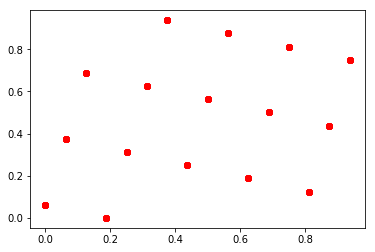

In [7]:
rn = rng_lcg(a=5, c=1, m=16, x0=3, l=100)[0]
plt.plot(rn[0:99], rn[1:100], 'ro')
plt.show()

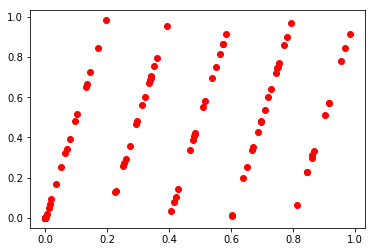

In [8]:
rn = rng_lcg(a=5, c=1, m=16097564936985763, x0=3, l=100)[0]
plt.plot(rn[0:99], rn[1:100], 'ro')
plt.show()

## 4. Independence Test of RNG Results

In [9]:
def cal_pvalue_chi2(stat, df):
    """Calculate the statistic according to Chi-Square distribution."""
    pvalue = 1 - st.chi2.cdf(stat, df)
    return pvalue

In [10]:
def cal_num_runs(li):
    """It is assumed that the input list is binary."""
    x1 = li[0]
    num_runs = 1
    for x in li:
        if x != x1:
            x1 = x
            num_runs += 1
    return num_runs

In [11]:
li = [1,1,1,0,1,1,1,0,0,1,1,0,0,1,1,1,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,1,1,0,0,0,1]
cal_num_runs(li)

19

Two-sided `Z`-test

In [12]:
def test_z(z):
    """Perform Z-test"""
    if z > 0:
        p_value = 2 * (1 - st.norm.cdf(z, 0, 1))
    else:
        p_value = 2 * st.norm.cdf(z, 0, 1)
    print(f'Z-test: p_value = {p_value:.4f}.')
    print(f'Is the p value smaller than 0.05? {p_value <= 0.05}.')
    print(f'If to reject the null hypothesis? {p_value <= 0.05}.')
    print(f'If to be random enough? {p_value >= 0.05}.')
    
    return p_value

In [13]:
test_z(0.45947)

Z-test: p_value = 0.6459.
Is the p value smaller than 0.05? False.
If to reject the null hypothesis? False.
If to be random enough? True.


0.6458966905687964

Two-sided `t`-test

In [14]:
def test_t(t, df, alpha:float=0.05):
    """Perform two-sided t-test"""
    p_value = 1 - st.chi2.cdf(t, df)
    print(f't-test: p_value = {p_value:.4f}.')
    print(f'Is the p value smaller than {alpha}? {p_value < alpha}.')
    print(f'If to reject the null hypothesis? {p_value <= 0.05}.')
    print(f'If to be random enough? {p_value >= 0.05}.')
    
    return p_value

In [15]:
test_t(2.46, 6)

t-test: p_value = 0.8729.
Is the p value smaller than 0.05? False.
If to reject the null hypothesis? False.
If to be random enough? True.


0.8729171686150026

### 4-1. Wald–Wolfowitz Runs Test

In [16]:
def get_binary_ww(li):
    """Transform the list to binary list."""
    m = np.median(li)
    li_binary = [1 if i > m else 0 for i in li]
    return li_binary

In [17]:
def cal_z_runs_ww(li):
    """Wald–Wolfowitz Runs Test"""
    n1 = sum(li)
    n2 = len(li) - n1
    
    ## Number of runs
    num_runs = cal_num_runs(li)    

    mu = (2 * n1 * n2) / (n1 + n2) + 1
    ## Standard error of the estimator
    se = math.sqrt( 2 * n1 * n2 * (2 * n1 * n2 - n1 - n2) / (n1 + n2)**2 / (n1 + n1 - 1) )
    z = (num_runs - mu) / se
    print(f'Wald–Wolfowitz Runs Test: z = {z:.4f}.')
    print(f'Number of runs: {num_runs}.')
    
    return z

In [18]:
li = [1,1,1,0,1,1,1,0,0,1,1,0,0,1,1,1,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,1,1,0,0,0,1]
z = cal_z_runs_ww(li)
test_z(z)

Wald–Wolfowitz Runs Test: z = -0.1322.
Number of runs: 19.
Z-test: p_value = 0.8948.
Is the p value smaller than 0.05? False.
If to reject the null hypothesis? False.
If to be random enough? True.


0.8948095012383603

In [19]:
li = [87.9,  64.7,  87.8,  74.9,  71.6,  84.9,  74.3,  76.5,  83.1,  77.5,  80.8,  75.1,
      85.6,  56.3,  89.0,  66.2,  68.0,  84.6,  81.2,  78.0,  87.1,  85.9,  84.7,  85.2,
      85.2,  83.7,  90.6,  82.4,  75.4,  78.3,  92.8,  79.6,  84.3,  86.3,  87.8,  93.6,
      97.4, 102.0,  98.7,  96.2, 100.3,  92.3,  95.1,  91.7,  96.7,  94.0,  94.7, 100.9,
      93.5, 100.4,  92.9,  99.0, 100.4,  90.2,  95.9,  94.8,  79.6,  78.8,  98.1,  97.9,
      93.0, 100.6,  81.3,  78.6,  81.9,  82.9,  80.9,  85.8,  78.0,  89.3]
li = get_binary_ww(li)
z = cal_z_runs_ww(li)
test_z(z)

Wald–Wolfowitz Runs Test: z = -4.5751.
Number of runs: 17.
Z-test: p_value = 0.0000.
Is the p value smaller than 0.05? True.
If to reject the null hypothesis? True.
If to be random enough? False.


4.758949927166804e-06

In [20]:
li = [rd.random() for i in range(10000)]
li = get_binary_ww(li)
z = cal_z_runs_ww(li)
test_z(z)

Wald–Wolfowitz Runs Test: z = -0.8400.
Number of runs: 4959.
Z-test: p_value = 0.4009.
Is the p value smaller than 0.05? False.
If to reject the null hypothesis? False.
If to be random enough? True.


0.40088483393454866

In [21]:
li = [5.36, 5.29, 5.58, 5.65, 5.57, 5.53, 5.62, 5.29, 5.44, 5.34, 5.79,
    5.10, 5.27, 5.39, 5.42, 5.47, 5.63, 5.34, 5.46, 5.30, 5.75, 5.68, 5.85]
li = get_binary_ww(li)
z = cal_z_runs_ww(li)
test_z(z)

Wald–Wolfowitz Runs Test: z = -1.8713.
Number of runs: 8.
Z-test: p_value = 0.0613.
Is the p value smaller than 0.05? False.
If to reject the null hypothesis? False.
If to be random enough? True.


0.06130770698094878

### 4-2. Knuth Runs Test

In [22]:
def analyse_ups(li):
    ups = {}
    x = li[0]
    len_run = 1
    num_runs = 1
    for i in li[1: len(li)]:
        if i > x:
            len_run += 1
        else:  # not up, so store the old run, and begin a new run
            ups[num_runs] = len_run
            num_runs += 1
            len_run = 1
        x = i
            
    ## add the last run
    ups[num_runs] = len_run
    num_runs += 1
    len_run = 1
    
    li_ups = list(ups.values())
    return li_ups

In [23]:
li = [0.54, 0.67, 0.13, 0.89, 0.33, 0.45, 0.90, 0.01, 0.45, 0.76, 0.82, 0.24, 0.17]
li_ups = analyse_ups(li)
li_ups

[2, 2, 3, 4, 1, 1]

In [24]:
def cal_t_runs_kunth(li_ups):
    r = np.zeros(6).reshape((6, 1))
    for j in range(5):
        r[j][0] = sum([i == j+1 for i in li_ups])
    r[5][0] = len(li_ups) - np.sum(r)
    
    a = np.array([
        [4529.4,9044.9,13568,18091,22615,27892],
        [9044.9,18097,27139,36187,45234,55789],
        [13568,27139,40721,54281,67852,83685],
        [18091,36187,54281,72414,90470,111580],
        [22615,45234,67852,90470,113262,139476],
        [27892,55789,83685,111580,139476,172860]])
    b = np.array([[(1)/(6)],[(5)/(24)],[(11)/(120)],[(19)/(720)],[(29)/(5040)],[(1)/(840)]])
    n = sum(li_ups)
    
    t = ( (r - n * b).transpose() @ a @ (r - n * b) )[0][0] / (n - 6)
    return t

In [25]:
t = cal_t_runs_kunth(li_ups)
t

2.859818369146385

In [26]:
test_t(t, 6)

t-test: p_value = 0.8262.
Is the p value smaller than 0.05? False.
If to reject the null hypothesis? False.
If to be random enough? True.


0.8262243090446957

In [27]:
li = [rd.random() for i in range(5000)]
li_ups = analyse_ups(li)
t = cal_t_runs_kunth(li_ups)
test_t(t, 6)

t-test: p_value = 0.5513.
Is the p value smaller than 0.05? False.
If to reject the null hypothesis? False.
If to be random enough? True.


0.5512541665623205

In [28]:
## The size of random number list must be larger than 6
li = [1, 2, 3, 4, 5, 6, 7, 8]
li_ups = analyse_ups(li)
t = cal_t_runs_kunth(li_ups)
test_t(t, 6)

t-test: p_value = 0.0000.
Is the p value smaller than 0.05? True.
If to reject the null hypothesis? True.
If to be random enough? False.


0.0

### 4-3. Up-and-Down Runs Test

> For this test the magnitude of each element is compared with that of its immediate predecessor in the given sequence. If the next element is larger we have a run-up: if smaller, a run-down. We thus observe whether the sequence increases or decreases and for how long. A decision concerning the pseudorandom number generator may then be based on the number and length of the runs. -- section 2.3.5 in [rubinstein1986simulation]

In [29]:
def get_binary_ud(li):
    li_diff = [li[i+1] - li[i] for i in range(0, len(li) - 1)]
    li_binary = [1 if i >= 0 else 0 for i in li_diff]
    return li_binary

In [30]:
def cal_z_runs_ud(li):
    """Up-and-Down Runs Test
    The hypothesis of randomness is rejected when the total number of runs is small.
    """
    num_runs = cal_num_runs(li)
    mu = (2 * num_runs - 1) / 3
    se = math.sqrt( (16*num_runs - 29) / 90 )
    z = (num_runs - mu) / se
    print(f'Up-and-Down Runs Test: z = {z:.4f}.')
    print(f'Number of runs: {num_runs}.')
    
    return z

In [31]:
li = [0.54, 0.67, 0.13, 0.89, 0.33, 0.45, 0.90, 0.01, 0.45, 0.76, 0.82, 0.24, 0.17]
li_binary = get_binary_ud(li)
z = cal_z_runs_ud(li_binary)
test_z(z)

Up-and-Down Runs Test: z = 2.8604.
Number of runs: 8.
Z-test: p_value = 0.0042.
Is the p value smaller than 0.05? True.
If to reject the null hypothesis? True.
If to be random enough? False.


0.004231232899758242

In [32]:
li = [rd.random() for i in range(1000)]
li_binary = get_binary_ud(li)
z = cal_z_runs_ud(li_binary)
test_z(z)

Up-and-Down Runs Test: z = 20.3074.
Number of runs: 656.
Z-test: p_value = 0.0000.
Is the p value smaller than 0.05? True.
If to reject the null hypothesis? True.
If to be random enough? False.


0.0

In [33]:
li = [0.2, 0.4, 0.1, 0.3, 0.6, 0.7, 0.5]
li_binary = get_binary_ud(li)
z = cal_z_runs_ud(li_binary)

Up-and-Down Runs Test: z = 2.6726.
Number of runs: 4.


## 5. Correlation Test

In [34]:
def cal_corr(li, h):
    n = len(li)
    s = [li[i] * li[i+h] for i in range(n - h)]    
    r = sum(s) / (n - h)
    mu = 0.25
    se = math.sqrt( 7 / 144 / n )

    z = (r - mu) / se
    return z

In [35]:
li = [1, 2, 3, 4, 5, 6, 7, 8]  
z = cal_corr(li, 2)
test_z(z)

Z-test: p_value = 0.0000.
Is the p value smaller than 0.05? True.
If to reject the null hypothesis? True.
If to be random enough? False.


0.0

In [36]:
li = [rd.random() for i in range(1000)]
z = cal_corr(li, 2)
test_z(z)

Z-test: p_value = 0.9954.
Is the p value smaller than 0.05? False.
If to reject the null hypothesis? False.
If to be random enough? True.


0.9954355179365568

## 6. Distribution Test

In [37]:
def test_dist(pvalue:float, alpha:float=0.05):
    """Perform distribution test of two populations."""
    print("Null hypothesis: two populations have the same distribution. \n" 
        f"The input p value is {pvalue:.4f}. \n"
        f"Is the p value smaller than {alpha}? {pvalue < alpha}. \n" 
        f"If reject the null hypothesis? {pvalue <= 0.05}. \n" 
        f"If from the same distribution? {pvalue >= 0.05}. \n")

### 6-1. `p`-value of  Kolmogorov–Smirnov Statistic

For now, I have tested that `cal_pvalue_ks()` have similar results to `schipy.stats.kstest()`.

- The question [How to interpret p-value of Kolmogorov-Smirnov test (python)?](https://stats.stackexchange.com/questions/57885/how-to-interpret-p-value-of-kolmogorov-smirnov-test-python) can be answered by showing the function `cal_pvalue_ks()`.
- It seems that the statistic follows Kolmogorovs distribution, and there is a function `scipy.stats.kstwobign.cdf()`. But I haven't obtained satifying test results.

In [38]:
def cal_pvalue_ks(d, n=10, m=1000):
    """Obtain the p-value corresponding a statistic from Kolmogorov–Smirnov Test.

    Keyword arguments:
    n -- sample size (default 10)
    m -- number of simulation runs (default 500)
    
    Returns:
    pvalue -- p-value
    """
    num_good = 0  # A counter to remember the number of good runs
    for i in range(m):
        u = [rd.random() for j in range(n)]
        u.sort()
        d_sim = [j / n - u[j] for j in range(1, (n-1))] + \
            [u[j] - (j-1) / n for j in range(1, (n-1))]
        ## If the value is larger than `d`, we say it is a good run.
        if max(d_sim) >= d:
            num_good += 1

    pvalue = num_good / m
    return pvalue

In [39]:
def exam_cal_pvalue_ks():
    n = 1000
    li = [rd.normalvariate(0, 1) for i in range(n)]
    d, pvalue_1 = st.kstest(rvs=li, cdf='norm', N=20)
    print(f'The resulted statistic is {d:.4f}.')
    print(f'The p-value calculated by `st.kstest()` is {pvalue_1:.4f}.')
    
    pvalue_2 = cal_pvalue_ks(d, n)
    print(f'The p-value calculated by `cal_pvalue_ks()` is {pvalue_2:.4f}.')

    
exam_cal_pvalue_ks()

The resulted statistic is 0.0235.
The p-value calculated by `st.kstest()` is 0.6367.
The p-value calculated by `cal_pvalue_ks()` is 0.6390.


### 6-2. One-Sample Kolmogorov–Smirnov Test

The Kolmogorov-Smirnov statistic for a given cumulative distribution function $F(x)$ is: 
$$ D_{n} = \sup_{x} \left|F_{n}(x) - F(x)\right| $$
where sup $_{x}$ is the supremum of the set of distances. By the Glivenko-Cantelli theorem, if the sample comes from distribution $F(x)$, then $D_{n}$ converges to 0 almost surely in the limit when $n$ goes to infinity. Kolmogorov strengthened this result, by effectively providing the rate of this convergence. Donsker's theorem provides a yet stronger result.

- [Difference between supremum and maximum, math.stackexchange](https://math.stackexchange.com/questions/160451/difference-between-supremum-and-maximum)
- `scipy.stats.kstest(rvs, cdf, args=(), N=20, alternative='two-sided', mode='approx')`
- [docs for random.py](https://docs.python.org/3/library/random.html)
- [Statistical functions (scipy.stats)](https://docs.scipy.org/doc/scipy/reference/stats.html)

In [40]:
def cal_stat_ks(li, f):
    """Calculate statistic in one-sample Kolmogorov–Smirnov test."""
    li.sort()
    n = len(li)
    li_new = [(j+1) / n - f(li[j]) for j in range(n)] + \
        [f(li[j]) - j / n  for j in range(n)]
    stat = max(li_new)
    print(f"One-sample Kolmogorov–Smirnov test: {stat:.4f}.")
    
    return stat

In [41]:
def exam_cal_stat_ks_1():
    n = 1000
    li = [rd.normalvariate(0, 1) for i in range(n)]
    d, _ = st.kstest(rvs=li, cdf='norm', N=20)
    print(f'The statistic calculated by `st.kstest()` is {d:.4f}.')
    
    d = cal_stat_ks(li, st.norm.cdf)

    
exam_cal_stat_ks_1()

The statistic calculated by `st.kstest()` is 0.0165.
One-sample Kolmogorov–Smirnov test: 0.0165.


In [42]:
def exam_cal_stat_ks_2():
    n = 1000
    li = [rd.uniform(0, 1) for i in range(n)]
    d, _ = st.kstest(rvs=li, cdf='uniform', N=20)
    print(f'The statistic calculated by `st.kstest()` is {d:.4f}.')
    
    d = cal_stat_ks(li, st.uniform.cdf)

    
exam_cal_stat_ks_2()

The statistic calculated by `st.kstest()` is 0.0277.
One-sample Kolmogorov–Smirnov test: 0.0277.


In [43]:
def exam_test_ks():
    """Examine one-sample KS test."""
    n = 1000
    li = [rd.normalvariate(0, 1) for i in range(n)]
    d = cal_stat_ks(li, st.norm.cdf)
    pvalue = cal_pvalue_ks(d, n)
    test_dist(pvalue)
    
    
exam_test_ks()

One-sample Kolmogorov–Smirnov test: 0.0558.
Null hypothesis: two populations have the same distribution. 
The input p value is 0.0040. 
Is the p value smaller than 0.05? True. 
If reject the null hypothesis? True. 
If from the same distribution? False. 



### 6-3. Two-Sample Kolmogorov–Smirnov Test

The Kolmogorov–Smirnov test may also be used to test whether two underlying one-dimensional probability distributions differ. In this case, the Kolmogorov-Smirnov statistic is
$$ D_{n, m} = \sup \left|F_{1, n}(x)-F_{2, m}(x)\right| $$

- `scipy.stats.ks_2samp(data1, data2, alternative='two-sided', mode='auto')`

### 6-4. Chi-Squared Goodness-of-Fit Test (GoF Test)

In [44]:
def count_gof(li:list, end_left:float=0, end_right:float=1, k:int=10):
    """Count numbers of samples in the different intervals in Chi-Squared Goodness-of-Fit Test
    
    Keyword arguments
    =================
    li:        list of samples to be tested
    end_left:  minimum possible value of the distribution
    end_right: maximum possible value of the distribution
    k:         number of intervals in the test.
    
    Returns
    =======
    counts: list of counts in different intervals
    ends:   list of left end of intervals
    """
    if end_left >= end_right:
        raise Exception("end_left >= end_right!")
    len_interval = (end_right - end_left) / k
    ends = [end_left + (i+1) * len_interval for i in range(k)]
    ends[-1] = end_right
    counts = [0 for i in range(k)]
    li.sort()
    
    j = 0
    i = 0
    counter = 0
    
    ## The left side is considered in the first interval    
    while li[i] == end_left:
        counter += 1
        i += 1

    while i < len(li):
        if li[i] <= ends[j] and li[i] > ends[j] - len_interval:
            counter += 1
            i += 1
        else:
            counts[j] = counter + 0
            while not (li[i] <= ends[j] and li[i] > ends[j] - len_interval):
                j += 1
            counter = 1
            i += 1
    counts[j] = counter + 0
            
    return counts, ends

In [45]:
def test_dist(pvalue:float, alpha:float=0.05):
    """Perform distribution test."""
    print("Null hypothesis: two populations have the same distribution. \n" 
        f"The input p value is {pvalue:.4f}. \n"
        f"Is the p value smaller than {alpha}? {pvalue < alpha}. \n" 
        f"If reject the null hypothesis? {pvalue <= 0.05}. \n" 
        f"If from the same distribution? {pvalue >= 0.05}. \n")

In [46]:
def exam_count_gof():
    li = [0, 0, 0.1, 0.05, 0.31, 0.32, 0.5]
    li_count, li_k = count_gof(li, 0, 0.5, 5)
    print(li_count)

    
exam_count_gof()

[4, 0, 0, 2, 1]


In [47]:
def cal_stat_gof(li_count, li_k, f):
    """Calculate the statistic in Goodness of Fit test."""
    li_cdf = [f(i) for i in li_k]
    li_p = [li_cdf[0]] + [li_cdf[i] - li_cdf[i-1] for i in range(1, len(li_cdf))]
    n = sum(li_count)
    k = len(li_p)
    stat = sum( [(li_count[i] - n * li_p[i])**2 / n / li_p[i] for i in range(k)] )
    print(f"Chi-squared goodness of fit test: {stat:.4f}.")
    
    return stat

In [48]:
def exam_gof():
    n = 1000
    k = 10
    li = [rd.uniform(0, 1) for i in range(n)]
    li_count, li_k = count_gof(li, 0, 1, k)
    print(li_count)
    
    f = st.uniform.cdf
    li_cdf = [f(i) for i in li_k]
    li_p = [li_cdf[0]] + [li_cdf[i] - li_cdf[i-1] for i in range(1, len(li_cdf))]
    print(li_p)
    
    stat = cal_stat_gof(li_count, li_k, st.uniform.cdf)
    
    pvalue = cal_pvalue_chi2(stat, df=k-1)
    test_dist(pvalue)
    
exam_gof()

[82, 86, 120, 110, 98, 107, 103, 97, 109, 88]
[0.1, 0.1, 0.10000000000000003, 0.09999999999999998, 0.09999999999999998, 0.10000000000000009, 0.09999999999999998, 0.09999999999999998, 0.09999999999999998, 0.09999999999999998]
Chi-squared goodness of fit test: 13.1600.
Null hypothesis: two populations have the same distribution. 
The input p value is 0.1555. 
Is the p value smaller than 0.05? False. 
If reject the null hypothesis? False. 
If from the same distribution? True. 



In [49]:
help(count_gof)

Help on function count_gof in module __main__:

count_gof(li: list, end_left: float = 0, end_right: float = 1, k: int = 10)
    Count numbers of samples in the different intervals in Chi-Squared Goodness-of-Fit Test
    
    Keyword arguments
    li:        list of samples to be tested
    end_left:  minimum possible value of the distribution
    end_right: maximum possible value of the distribution
    k:         number of intervals in the test.
    
    Returns
    counts: list of counts in different intervals
    ends:   list of left end of intervals



In [50]:
def exam_gof_2():
    li_count = [12,5,19,7,7]
    li_p = [0.2 for i in range(5)]
    n = sum(li_count)
    k = len(li_p)
    stat = sum( [(li_count[i] - n * li_p[i])**2 / n / li_p[i] for i in range(k)] )
    print(stat)
    
    pvalue = cal_pvalue_chi2(stat, df=k-1)
    test_dist(pvalue, 0.01)
    

exam_gof_2()

12.8
Null hypothesis: two populations have the same distribution. 
The input p value is 0.0123. 
Is the p value smaller than 0.01? False. 
If reject the null hypothesis? True. 
If from the same distribution? False. 

